<a href="https://colab.research.google.com/github/srivatsan88/YouTubeLI/blob/master/Model_Architecture_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to video accompanying this notebook - https://www.youtube.com/watch?v=-7TZ-IKMJi8

In [ ]:
!git clone https://github.com/google/model_search.git

Cloning into 'model_search'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 134 (delta 26), reused 129 (delta 24), pack-reused 0
Receiving objects: 100% (134/134), 212.98 KiB | 12.53 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
%cd model_search
!pwd

/content/model_search
/content/model_search


In [ ]:
!ls 

LICENSE  model_search  README.md  requirements.txt  WORKSPACE


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 358kB 72kB/s 
     |████████████████████████████████| 2.8MB 44.5MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 460kB 55.9MB/s 
     |████████████████████████████████| 3.0MB 49.2MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=adb1554eb0fa36f850090f2567d2a572618ed1d0a21a1d61f0e2c19905a7700f
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=7efb03f8a883baa199f58c4e981efa1ba79610153bd387c79c43a9c20e95f4db
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tens

In [ ]:
!ls model_search

architecture		hparam.py	     phoenix.py
blocks_builder.py	images		     phoenix_test.py
blocks_builder_test.py	__init__.py	     proto
blocks.py		logit_bundler.py     registry.py
blocks_test.py		loss_fns.py	     registry_test.py
BUILD			loss_fns_test.py     search
configs			meta		     single_trainer.py
constants.py		metadata	     single_trainer_test.py
controller.py		metric_fns.py	     task_manager.py
controller_test.py	metric_fns_test.py   task_manager_test.py
data			ops		     testdata
ensembler.py		oss_trainer_lib.py   trainer.bzl
ensembler_test.py	oss_trainer.py	     utils.py
generators		oss_trainer_test.py  utils_test.py


In [ ]:
!protoc --python_out=./ model_search/proto/phoenix_spec.proto
!protoc --python_out=./ model_search/proto/hparam.proto
!protoc --python_out=./ model_search/proto/distillation_spec.proto
!protoc --python_out=./ model_search/proto/ensembling_spec.proto
!protoc --python_out=./ model_search/proto/transfer_learning_spec.proto

In [ ]:
!wget -O credit_default.xls https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

--2021-02-21 02:27:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘credit_default.xls’

credit_default.xls  100%[===================>]   5.28M  9.42MB/s    in 0.6s    

2021-02-21 02:27:06 (9.42 MB/s) - ‘credit_default.xls’ saved [5539328/5539328]



In [ ]:
!ls

credit_default.xls  model_search  requirements.txt
LICENSE		    README.md	  WORKSPACE


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import model_search
from model_search import constants
from model_search import single_trainer
from model_search.data import csv_data


In [ ]:
data=pd.read_excel('credit_default.xls',skiprows=1)
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [ ]:
data=data.rename({'default payment next month':'default'}, axis=1)

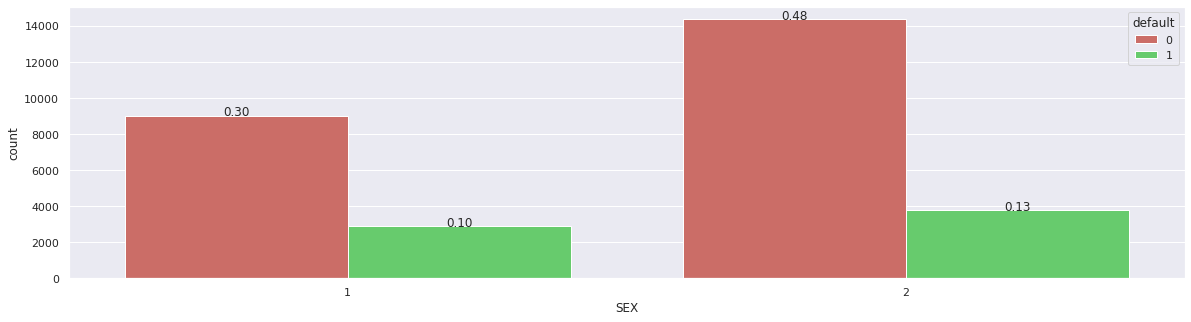

In [ ]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="SEX", hue="default", data=data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/data.shape[0]),
            ha="center") 

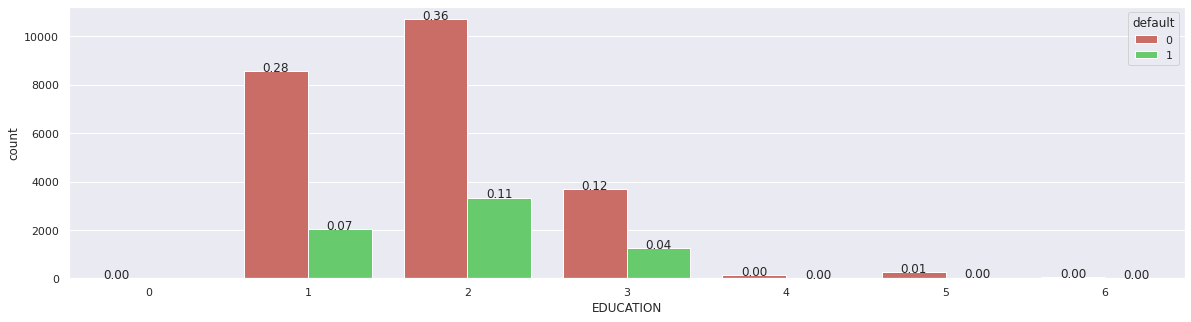

In [ ]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="EDUCATION", hue="default", data=data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/data.shape[0]),
            ha="center") 

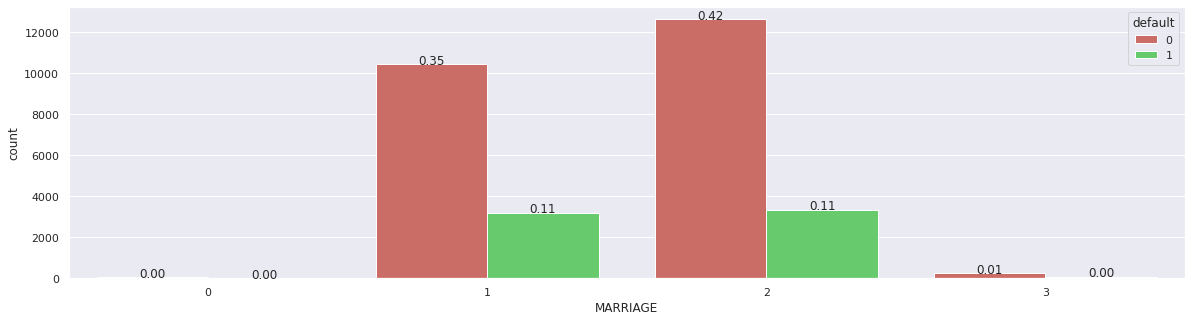

In [ ]:
sns.set(style="darkgrid")
sns.set_palette("hls", 3)
fig, ax = plt.subplots(figsize=(20,5))
ax = sns.countplot(x="MARRIAGE", hue="default", data=data)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/data.shape[0]),
            ha="center") 

In [ ]:
categorical=['SEX',	'EDUCATION',	'MARRIAGE']
numeric=['PAY_0',	'PAY_2',	'PAY_3',	'PAY_4',	'PAY_5',	'PAY_6']

In [ ]:
data_final=pd.get_dummies(data=data[categorical], columns=['SEX',	'EDUCATION',	'MARRIAGE'])
data_final

,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0,1,0,0,1,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1,0,0,0,0,1,0,0,0,0,1,0,0
29996,1,0,0,0,0,1,0,0,0,0,0,1,0
29997,1,0,0,0,1,0,0,0,0,0,0,1,0
29998,1,0,0,0,0,1,0,0,0,0,1,0,0


In [ ]:
data_default=pd.concat([data['default'], data_final, data[numeric]],  axis=1)
data_default

,default,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,2,2,-1,-1,-2,-2
1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,-1,2,0,0,0,2
2,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,0,1,0,0,-1,0,-1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
29996,0,1,0,0,0,0,1,0,0,0,0,0,1,0,-1,-1,-1,-1,0,0
29997,1,1,0,0,0,1,0,0,0,0,0,0,1,0,4,3,2,-1,0,0
29998,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,-1,0,0,0,-1


In [ ]:
data_default['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [ ]:
data_default.to_csv('default.csv',sep = ',', index = False, header = None)

In [ ]:
trainer = single_trainer.SingleTrainer(
    data=csv_data.Provider(label_index=0, logits_dimension=2, record_defaults=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], filename="default.csv"),
    spec='model_search/configs/dnn_config.pbtxt')

In [ ]:
!mkdir /tmp/run_example

In [ ]:
!rm -r /tmp/run_example/

In [ ]:
import sys
from absl import app

# Addresses `UnrecognizedFlagError: Unknown command line flag 'f'`
sys.argv = sys.argv[:1]

# `app.run` calls `sys.exit`
try:
  app.run(lambda argv: None)
except:
  pass

In [ ]:
trainer.try_models(
    number_models=5,
    train_steps=5,
    eval_steps=1,
    root_dir="/tmp/run_example",
    batch_size=512,
    experiment_name="example",
    experiment_owner="model_search_user")

I0221 02:38:11.334247 139980907059072 metadata_store.py:93] MetadataStore with DB connection initialized
I0221 02:38:11.348391 139980907059072 oss_trainer_lib.py:281] creating directory: /tmp/run_example/tuner-1/1
I0221 02:38:11.349477 139980907059072 oss_trainer_lib.py:328] Tuner id: tuner-1
I0221 02:38:11.350177 139980907059072 oss_trainer_lib.py:329] Training with the following hyperparameters: 
I0221 02:38:11.350818 139980907059072 oss_trainer_lib.py:330] {'learning_rate': 1.2356858395568012e-05, 'new_block_type': 'FULLY_CONNECTED_RESIDUAL_PROJECT', 'optimizer': 'adagrad', 'initial_architecture_0': 'FULLY_CONNECTED_RESIDUAL_PROJECT_BATCHNORM', 'exponential_decay_rate': 0.927511803144641, 'exponential_decay_steps': 1, 'gradient_max_norm': 4, 'dropout_rate': 0.3000000104308128, 'initial_architecture': ['FULLY_CONNECTED_RESIDUAL_PROJECT_BATCHNORM']}


INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/1', 'session_master': ''}


I0221 02:38:11.351745 139980907059072 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/1', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/1


I0221 02:38:11.353013 139980907059072 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/1


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/1', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0221 02:38:11.359515 139980907059072 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/1', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


W0221 02:38:11.377883 139980907059072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1666: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


W0221 02:38:11.380550 139980907059072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


I0221 02:38:12.792375 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:38:12.803065 139980907059072 controller.py:160] trial id: 1
I0221 02:38:12.803897 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:38:12.812008 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[]), 'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7f4f4be23d68>, relevant_trials=[])}
I0221 02:38:12.813612 139980907059072 search_candidate_generator.py:77] Creating new architecture: 
I0221 02:38:12.814503 139980907059072 search_candidate_generator.py:78] [84]


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


W0221 02:38:12.925185 139980907059072 deprecation.py:323] From /content/model_search/model_search/blocks.py:489: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


W0221 02:38:12.930278 139980907059072 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/layers/normalization.py:336: Layer.apply (from tensorflow.python.keras.engine.base_layer_v1) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Use keras.layers.dropout instead.


W0221 02:38:12.964275 139980907059072 deprecation.py:323] From /content/model_search/model_search/architecture/architecture_utils.py:430: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
I0221 02:38:12.998453 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[]), 'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7f4f4be23d68>, relevant_trials=[])}


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0221 02:38:13.146956 139980907059072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/adagrad.py:77: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


W0221 02:38:13.192001 139980907059072 deprecation.py:323] From /content/model_search/model_search/metric_fns.py:204: auc (from tensorflow.python.ops.metrics_impl) is deprecated and will be removed in a future version.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


INFO:tensorflow:Done calling model_fn.


I0221 02:38:13.392438 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0221 02:38:13.396190 139980907059072 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0221 02:38:13.562232 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0221 02:38:14.227515 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:38:14.245839 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0221 02:38:14.635976 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/1/model.ckpt.


I0221 02:38:14.640518 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/1/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0221 02:38:14.726129 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0221 02:41:19.554252 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/1/model.ckpt.


I0221 02:41:19.556570 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/1/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0221 02:41:19.625118 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 1.959062, step = 0


I0221 02:41:19.629289 139980907059072 basic_session_run_hooks.py:262] loss = 1.959062, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0221 02:41:19.763242 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/1/model.ckpt.


I0221 02:41:19.768287 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/1/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0221 02:41:19.840722 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 1.9751744.


I0221 02:41:22.225699 139980907059072 estimator.py:350] Loss for final step: 1.9751744.


INFO:tensorflow:Calling model_fn.


I0221 02:41:22.278923 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:41:22.292946 139980907059072 controller.py:160] trial id: 1
I0221 02:41:22.293539 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:41:22.301253 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[]), 'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7f4f4be23d68>, relevant_trials=[])}
I0221 02:41:22.304786 139980907059072 base_tower_generator.py:112] Building from existing checkpoint.
I0221 02:41:22.459856 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[]), 'prior_generator': GeneratorWithTrials(instance=<model_se

INFO:tensorflow:Done calling model_fn.


I0221 02:41:22.693220 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-02-21T02:41:22Z


I0221 02:41:22.715737 139980907059072 evaluation.py:255] Starting evaluation at 2021-02-21T02:41:22Z


INFO:tensorflow:Graph was finalized.


I0221 02:41:22.785378 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/1/model.ckpt-5


I0221 02:41:22.797143 139980907059072 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/1/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0221 02:41:22.854010 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:41:22.872920 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0221 02:41:23.021544 139980907059072 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.34682s


I0221 02:41:23.063818 139980907059072 evaluation.py:273] Inference Time : 0.34682s


INFO:tensorflow:Finished evaluation at 2021-02-21-02:41:23


I0221 02:41:23.066565 139980907059072 evaluation.py:276] Finished evaluation at 2021-02-21-02:41:23


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.34960938, auc_pr = 0.20678453, auc_roc = 0.4399273, global_step = 5, loss = 1.5822204, num_parameters = 458


I0221 02:41:23.074224 139980907059072 estimator.py:2066] Saving dict for global step 5: accuracy = 0.34960938, auc_pr = 0.20678453, auc_roc = 0.4399273, global_step = 5, loss = 1.5822204, num_parameters = 458


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/1/model.ckpt-5


I0221 02:41:23.172427 139980907059072 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/1/model.ckpt-5
I0221 02:41:23.176488 139980907059072 phoenix.py:123] Saving the following evaluation dictionary.
I0221 02:41:23.177171 139980907059072 phoenix.py:124] {'accuracy': 0.349609375, 'auc_pr': 0.20678453147411346, 'auc_roc': 0.4399273097515106, 'loss': 1.582220435142517, 'num_parameters': 458, 'global_step': 5}
I0221 02:41:23.178584 139980907059072 ml_metadata_db.py:156] Storing the following evaluation dictionary,
I0221 02:41:23.180677 139980907059072 ml_metadata_db.py:157] {'accuracy': 0.349609375, 'auc_pr': 0.20678453147411346, 'auc_roc': 0.4399273097515106, 'loss': 1.582220435142517, 'num_parameters': 458, 'global_step': 5}
I0221 02:41:23.182441 139980907059072 ml_metadata_db.py:158] For the model in the following model dictionary,
I0221 02:41:23.183615 139980907059072 ml_metadata_db.py:159] /tmp/run_example/tuner-1/1
I0221 02:41:23.197746 

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/2', 'session_master': ''}


I0221 02:41:23.207884 139980907059072 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/2', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/2


I0221 02:41:23.213845 139980907059072 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/2


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/2', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0221 02:41:23.222628 139980907059072 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/2', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0221 02:41:23.286033 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:41:23.298420 139980907059072 controller.py:160] trial id: 2
I0221 02:41:23.299196 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:41:23.312570 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4eee40cdd8>])}
I0221 02:41:23.321707 139980907059072 coordinate_descent.py:58] Maximal depth allowed: 1
I0221 02:41:23.322523 139980907059072 coordinate_descent.py:70] using evolution
I0221 02:41:23.325140 139980907059072 search_candidate_generator.py:77] Creating new architecture: 
I0221 02:41:23.328673 139980907059072 search_candidate_generator.py:78] [83]


INFO:tensorflow:Done calling model_fn.


I0221 02:41:23.936395 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0221 02:41:23.939580 139980907059072 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0221 02:41:24.092931 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0221 02:41:24.161454 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:41:24.180850 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0221 02:41:24.537400 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/2/model.ckpt.


I0221 02:41:24.539430 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/2/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0221 02:41:24.625238 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0221 02:44:26.567297 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/2/model.ckpt.


I0221 02:44:26.571324 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/2/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0221 02:44:26.646031 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 1.0785302, step = 0


I0221 02:44:26.649383 139980907059072 basic_session_run_hooks.py:262] loss = 1.0785302, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0221 02:44:26.756093 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/2/model.ckpt.


I0221 02:44:26.758613 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/2/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0221 02:44:26.826027 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 1.0202022.


I0221 02:44:27.820748 139980907059072 estimator.py:350] Loss for final step: 1.0202022.


INFO:tensorflow:Calling model_fn.


I0221 02:44:27.876107 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:44:27.889086 139980907059072 controller.py:160] trial id: 2
I0221 02:44:27.889642 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:44:27.899160 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4eee4053c8>])}
I0221 02:44:27.902883 139980907059072 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0221 02:44:28.259547 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-02-21T02:44:28Z


I0221 02:44:28.283542 139980907059072 evaluation.py:255] Starting evaluation at 2021-02-21T02:44:28Z


INFO:tensorflow:Graph was finalized.


I0221 02:44:28.342009 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/2/model.ckpt-5


I0221 02:44:28.355096 139980907059072 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/2/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0221 02:44:28.413965 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:44:28.436195 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0221 02:44:28.590651 139980907059072 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.34574s


I0221 02:44:28.630686 139980907059072 evaluation.py:273] Inference Time : 0.34574s


INFO:tensorflow:Finished evaluation at 2021-02-21-02:44:28


I0221 02:44:28.637678 139980907059072 evaluation.py:276] Finished evaluation at 2021-02-21-02:44:28


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.38085938, auc_pr = 0.2555536, auc_roc = 0.5195925, global_step = 5, loss = 0.9815643, num_parameters = 420


I0221 02:44:28.639367 139980907059072 estimator.py:2066] Saving dict for global step 5: accuracy = 0.38085938, auc_pr = 0.2555536, auc_roc = 0.5195925, global_step = 5, loss = 0.9815643, num_parameters = 420


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/2/model.ckpt-5


I0221 02:44:28.744191 139980907059072 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/2/model.ckpt-5
I0221 02:44:28.747076 139980907059072 phoenix.py:123] Saving the following evaluation dictionary.
I0221 02:44:28.747990 139980907059072 phoenix.py:124] {'accuracy': 0.380859375, 'auc_pr': 0.25555360317230225, 'auc_roc': 0.5195925235748291, 'loss': 0.9815642833709717, 'num_parameters': 420, 'global_step': 5}
I0221 02:44:28.748655 139980907059072 ml_metadata_db.py:156] Storing the following evaluation dictionary,
I0221 02:44:28.749444 139980907059072 ml_metadata_db.py:157] {'accuracy': 0.380859375, 'auc_pr': 0.25555360317230225, 'auc_roc': 0.5195925235748291, 'loss': 0.9815642833709717, 'num_parameters': 420, 'global_step': 5}
I0221 02:44:28.750175 139980907059072 ml_metadata_db.py:158] For the model in the following model dictionary,
I0221 02:44:28.750962 139980907059072 ml_metadata_db.py:159] /tmp/run_example/tuner-1/2
I0221 02:44:28.76572

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/3', 'session_master': ''}


I0221 02:44:28.780483 139980907059072 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/3', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/3


I0221 02:44:28.782218 139980907059072 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/3


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/3', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0221 02:44:28.784088 139980907059072 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/3', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0221 02:44:28.863318 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:44:28.876713 139980907059072 controller.py:160] trial id: 3
I0221 02:44:28.877386 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:44:28.891098 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4f406631d0>, <model_search.metadata.trial.Trial object at 0x7f4f40663198>])}
I0221 02:44:28.896418 139980907059072 coordinate_descent.py:58] Maximal depth allowed: 1
I0221 02:44:28.897042 139980907059072 coordinate_descent.py:70] using evolution
I0221 02:44:28.901056 139980907059072 search_candidate_generator.py:77] Creating new architecture: 
I0221 02:44:28.903527 139980907059072 search_candidate_generator.py:78] [24]


INFO:tensorflow:Done calling model_fn.


I0221 02:44:29.350854 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0221 02:44:29.354187 139980907059072 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0221 02:44:29.509219 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0221 02:44:29.589609 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:44:29.609450 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0221 02:44:29.967242 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/3/model.ckpt.


I0221 02:44:29.969223 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0221 02:44:30.050102 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0221 02:47:33.658199 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/3/model.ckpt.


I0221 02:47:33.659987 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0221 02:47:33.734372 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 0.67473567, step = 0


I0221 02:47:33.737831 139980907059072 basic_session_run_hooks.py:262] loss = 0.67473567, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0221 02:47:33.843993 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/3/model.ckpt.


I0221 02:47:33.846507 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/3/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0221 02:47:33.916832 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 0.66991615.


I0221 02:47:34.686617 139980907059072 estimator.py:350] Loss for final step: 0.66991615.


INFO:tensorflow:Calling model_fn.


I0221 02:47:34.738690 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:47:34.754972 139980907059072 controller.py:160] trial id: 3
I0221 02:47:34.755545 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:47:34.766895 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4f40185dd8>, <model_search.metadata.trial.Trial object at 0x7f4f40185c18>])}
I0221 02:47:34.771934 139980907059072 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0221 02:47:35.126415 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-02-21T02:47:35Z


I0221 02:47:35.155249 139980907059072 evaluation.py:255] Starting evaluation at 2021-02-21T02:47:35Z


INFO:tensorflow:Graph was finalized.


I0221 02:47:35.216627 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/3/model.ckpt-5


I0221 02:47:35.231606 139980907059072 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/3/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0221 02:47:35.295526 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:47:35.318450 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0221 02:47:35.473140 139980907059072 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.36534s


I0221 02:47:35.521611 139980907059072 evaluation.py:273] Inference Time : 0.36534s


INFO:tensorflow:Finished evaluation at 2021-02-21-02:47:35


I0221 02:47:35.525986 139980907059072 evaluation.py:276] Finished evaluation at 2021-02-21-02:47:35


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.75, auc_pr = 0.17559887, auc_roc = 0.33505315, global_step = 5, loss = 0.6543475, num_parameters = 11266


I0221 02:47:35.532362 139980907059072 estimator.py:2066] Saving dict for global step 5: accuracy = 0.75, auc_pr = 0.17559887, auc_roc = 0.33505315, global_step = 5, loss = 0.6543475, num_parameters = 11266


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/3/model.ckpt-5


I0221 02:47:35.634849 139980907059072 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/3/model.ckpt-5
I0221 02:47:35.638068 139980907059072 phoenix.py:123] Saving the following evaluation dictionary.
I0221 02:47:35.638808 139980907059072 phoenix.py:124] {'accuracy': 0.75, 'auc_pr': 0.1755988746881485, 'auc_roc': 0.33505314588546753, 'loss': 0.6543474793434143, 'num_parameters': 11266, 'global_step': 5}
I0221 02:47:35.639453 139980907059072 ml_metadata_db.py:156] Storing the following evaluation dictionary,
I0221 02:47:35.640160 139980907059072 ml_metadata_db.py:157] {'accuracy': 0.75, 'auc_pr': 0.1755988746881485, 'auc_roc': 0.33505314588546753, 'loss': 0.6543474793434143, 'num_parameters': 11266, 'global_step': 5}
I0221 02:47:35.642724 139980907059072 ml_metadata_db.py:158] For the model in the following model dictionary,
I0221 02:47:35.643489 139980907059072 ml_metadata_db.py:159] /tmp/run_example/tuner-1/3
I0221 02:47:35.660532 13998090

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/4', 'session_master': ''}


I0221 02:47:35.677698 139980907059072 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/4', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/4


I0221 02:47:35.682060 139980907059072 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/4


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/4', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0221 02:47:35.687608 139980907059072 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/4', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0221 02:47:35.755310 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:47:35.771758 139980907059072 controller.py:160] trial id: 4
I0221 02:47:35.772477 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:47:35.783336 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4f4bc57278>, <model_search.metadata.trial.Trial object at 0x7f4f4bc572e8>, <model_search.metadata.trial.Trial object at 0x7f4f4bc57320>])}
I0221 02:47:35.786775 139980907059072 coordinate_descent.py:58] Maximal depth allowed: 1
I0221 02:47:35.787346 139980907059072 coordinate_descent.py:70] using evolution
I0221 02:47:35.796588 139980907059072 search_candidate_generator.py:77] Creating new architecture: 
I0221 02:47:35.797297 139980907059072 search_candidate_generator.py:78] [22]


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0221 02:47:36.031158 139980907059072 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/rmsprop.py:123: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


I0221 02:47:36.268189 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0221 02:47:36.271388 139980907059072 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0221 02:47:36.439524 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0221 02:47:36.523710 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:47:36.544095 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0221 02:47:36.935825 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/4/model.ckpt.


I0221 02:47:36.938471 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0221 02:47:37.025712 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1...


I0221 02:50:39.697536 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 1...


INFO:tensorflow:Saving checkpoints for 1 into /tmp/run_example/tuner-1/4/model.ckpt.


I0221 02:50:39.701515 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 1 into /tmp/run_example/tuner-1/4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1...


I0221 02:50:39.776060 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 1...


INFO:tensorflow:loss = 0.6283448, step = 0


I0221 02:50:39.779385 139980907059072 basic_session_run_hooks.py:262] loss = 0.6283448, step = 0


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 5...


I0221 02:50:39.883088 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 5...


INFO:tensorflow:Saving checkpoints for 5 into /tmp/run_example/tuner-1/4/model.ckpt.


I0221 02:50:39.884389 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 5 into /tmp/run_example/tuner-1/4/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 5...


I0221 02:50:39.968142 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 5...


INFO:tensorflow:Loss for final step: 0.626469.


I0221 02:50:40.791769 139980907059072 estimator.py:350] Loss for final step: 0.626469.


INFO:tensorflow:Calling model_fn.


I0221 02:50:40.842913 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:50:40.861634 139980907059072 controller.py:160] trial id: 4
I0221 02:50:40.862226 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:50:40.874369 139980907059072 phoenix.py:371] {'search_generator': GeneratorWithTrials(instance=<model_search.generators.search_candidate_generator.SearchCandidateGenerator object at 0x7f4f4be23860>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4f4b9dfa90>, <model_search.metadata.trial.Trial object at 0x7f4f4b9eebe0>, <model_search.metadata.trial.Trial object at 0x7f4f4b9ee9b0>])}
I0221 02:50:40.876475 139980907059072 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0221 02:50:41.405051 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-02-21T02:50:41Z


I0221 02:50:41.430373 139980907059072 evaluation.py:255] Starting evaluation at 2021-02-21T02:50:41Z


INFO:tensorflow:Graph was finalized.


I0221 02:50:41.488251 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/4/model.ckpt-5


I0221 02:50:41.503420 139980907059072 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/4/model.ckpt-5


INFO:tensorflow:Running local_init_op.


I0221 02:50:41.565973 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:50:41.587437 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0221 02:50:41.745009 139980907059072 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.36207s


I0221 02:50:41.793590 139980907059072 evaluation.py:273] Inference Time : 0.36207s


INFO:tensorflow:Finished evaluation at 2021-02-21-02:50:41


I0221 02:50:41.797935 139980907059072 evaluation.py:276] Finished evaluation at 2021-02-21-02:50:41


INFO:tensorflow:Saving dict for global step 5: accuracy = 0.7089844, auc_pr = 0.34997013, auc_roc = 0.6056905, global_step = 5, loss = 0.61839694, num_parameters = 2818


I0221 02:50:41.803376 139980907059072 estimator.py:2066] Saving dict for global step 5: accuracy = 0.7089844, auc_pr = 0.34997013, auc_roc = 0.6056905, global_step = 5, loss = 0.61839694, num_parameters = 2818


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/4/model.ckpt-5


I0221 02:50:41.907973 139980907059072 estimator.py:2127] Saving 'checkpoint_path' summary for global step 5: /tmp/run_example/tuner-1/4/model.ckpt-5
I0221 02:50:41.916349 139980907059072 phoenix.py:123] Saving the following evaluation dictionary.
I0221 02:50:41.917126 139980907059072 phoenix.py:124] {'accuracy': 0.708984375, 'auc_pr': 0.34997013211250305, 'auc_roc': 0.6056904792785645, 'loss': 0.6183969378471375, 'num_parameters': 2818, 'global_step': 5}
I0221 02:50:41.919507 139980907059072 ml_metadata_db.py:156] Storing the following evaluation dictionary,
I0221 02:50:41.920351 139980907059072 ml_metadata_db.py:157] {'accuracy': 0.708984375, 'auc_pr': 0.34997013211250305, 'auc_roc': 0.6056904792785645, 'loss': 0.6183969378471375, 'num_parameters': 2818, 'global_step': 5}
I0221 02:50:41.921144 139980907059072 ml_metadata_db.py:158] For the model in the following model dictionary,
I0221 02:50:41.921950 139980907059072 ml_metadata_db.py:159] /tmp/run_example/tuner-1/4
I0221 02:50:41.936

INFO:tensorflow:TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/5', 'session_master': ''}


I0221 02:50:41.946243 139980907059072 run_config.py:550] TF_CONFIG environment variable: {'model_dir': '/tmp/run_example/tuner-1/5', 'session_master': ''}


INFO:tensorflow:Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/5


I0221 02:50:41.948338 139980907059072 run_config.py:973] Using model_dir in TF_CONFIG: /tmp/run_example/tuner-1/5


INFO:tensorflow:Using config: {'_model_dir': '/tmp/run_example/tuner-1/5', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0221 02:50:41.950269 139980907059072 estimator.py:191] Using config: {'_model_dir': '/tmp/run_example/tuner-1/5', '_tf_random_seed': None, '_save_summary_steps': 2000, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 120, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


I0221 02:50:42.034504 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:50:42.049689 139980907059072 controller.py:160] trial id: 5
I0221 02:50:42.051829 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:50:42.064352 139980907059072 phoenix.py:371] {'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7f4f4be23d68>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4f4bcd16d8>, <model_search.metadata.trial.Trial object at 0x7f4f4bcd1668>, <model_search.metadata.trial.Trial object at 0x7f4f400aa710>, <model_search.metadata.trial.Trial object at 0x7f4f40224c50>])}
I0221 02:50:42.230981 139980907059072 architecture_utils.py:347] warm starting the following tensors
I0221 02:50:42.231668 139980907059072 architecture_utils.py:348] {'Phoenix/search_generator_0/1_FULLY_CONNECTED_RESIDUAL_PROJECT_BATCHNORM_84/dense/kernel': <tf.Variable 'Phoenix/prior_generator_0/1_FULLY_CONNECTED_

INFO:tensorflow:Done calling model_fn.


I0221 02:50:42.797597 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0221 02:50:42.801725 139980907059072 basic_session_run_hooks.py:546] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0221 02:50:43.031439 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0221 02:50:43.144078 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:50:43.166424 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


I0221 02:50:43.666850 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/run_example/tuner-1/5/model.ckpt.


I0221 02:50:43.669016 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 0 into /tmp/run_example/tuner-1/5/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


I0221 02:50:43.793369 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 101...


I0221 02:53:46.070345 139980907059072 basic_session_run_hooks.py:614] Calling checkpoint listeners before saving checkpoint 101...


INFO:tensorflow:Saving checkpoints for 101 into /tmp/run_example/tuner-1/5/model.ckpt.


I0221 02:53:46.072720 139980907059072 basic_session_run_hooks.py:618] Saving checkpoints for 101 into /tmp/run_example/tuner-1/5/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 101...


I0221 02:53:46.179202 139980907059072 basic_session_run_hooks.py:626] Calling checkpoint listeners after saving checkpoint 101...


INFO:tensorflow:loss = 0.9071616, step = 0


I0221 02:53:46.189086 139980907059072 basic_session_run_hooks.py:262] loss = 0.9071616, step = 0


INFO:tensorflow:Loss for final step: 0.9071616.


I0221 02:53:46.937960 139980907059072 estimator.py:350] Loss for final step: 0.9071616.


INFO:tensorflow:Calling model_fn.


I0221 02:53:46.989022 139980907059072 estimator.py:1169] Calling model_fn.
I0221 02:53:47.004633 139980907059072 controller.py:160] trial id: 5
I0221 02:53:47.005333 139980907059072 controller.py:239] intermix ensemble search mode
I0221 02:53:47.015306 139980907059072 phoenix.py:371] {'prior_generator': GeneratorWithTrials(instance=<model_search.generators.prior_generator.PriorGenerator object at 0x7f4f4be23d68>, relevant_trials=[<model_search.metadata.trial.Trial object at 0x7f4f4b377898>, <model_search.metadata.trial.Trial object at 0x7f4f4b377be0>, <model_search.metadata.trial.Trial object at 0x7f4f4b377fd0>, <model_search.metadata.trial.Trial object at 0x7f4f4b377550>])}
I0221 02:53:47.025744 139980907059072 base_tower_generator.py:112] Building from existing checkpoint.


INFO:tensorflow:Done calling model_fn.


I0221 02:53:47.654880 139980907059072 estimator.py:1171] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-02-21T02:53:47Z


I0221 02:53:47.678519 139980907059072 evaluation.py:255] Starting evaluation at 2021-02-21T02:53:47Z


INFO:tensorflow:Graph was finalized.


I0221 02:53:47.760427 139980907059072 monitored_session.py:246] Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/run_example/tuner-1/5/model.ckpt-101


I0221 02:53:47.770669 139980907059072 saver.py:1293] Restoring parameters from /tmp/run_example/tuner-1/5/model.ckpt-101


INFO:tensorflow:Running local_init_op.


I0221 02:53:47.868260 139980907059072 session_manager.py:505] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0221 02:53:47.893693 139980907059072 session_manager.py:508] Done running local_init_op.


INFO:tensorflow:Evaluation [1/1]


I0221 02:53:48.106552 139980907059072 evaluation.py:167] Evaluation [1/1]


INFO:tensorflow:Inference Time : 0.48022s


I0221 02:53:48.161740 139980907059072 evaluation.py:273] Inference Time : 0.48022s


INFO:tensorflow:Finished evaluation at 2021-02-21-02:53:48


I0221 02:53:48.162966 139980907059072 evaluation.py:276] Finished evaluation at 2021-02-21-02:53:48


INFO:tensorflow:Saving dict for global step 101: accuracy = 0.37109375, auc_pr = 0.21577671, auc_roc = 0.44417235, global_step = 101, loss = 0.81824654, num_parameters = 14542


I0221 02:53:48.169629 139980907059072 estimator.py:2066] Saving dict for global step 101: accuracy = 0.37109375, auc_pr = 0.21577671, auc_roc = 0.44417235, global_step = 101, loss = 0.81824654, num_parameters = 14542


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 101: /tmp/run_example/tuner-1/5/model.ckpt-101


I0221 02:53:48.331310 139980907059072 estimator.py:2127] Saving 'checkpoint_path' summary for global step 101: /tmp/run_example/tuner-1/5/model.ckpt-101
I0221 02:53:48.333303 139980907059072 phoenix.py:123] Saving the following evaluation dictionary.
I0221 02:53:48.334015 139980907059072 phoenix.py:124] {'accuracy': 0.37109375, 'auc_pr': 0.2157767117023468, 'auc_roc': 0.44417235255241394, 'loss': 0.8182465434074402, 'num_parameters': 14542, 'global_step': 101}
I0221 02:53:48.334595 139980907059072 ml_metadata_db.py:156] Storing the following evaluation dictionary,
I0221 02:53:48.336226 139980907059072 ml_metadata_db.py:157] {'accuracy': 0.37109375, 'auc_pr': 0.2157767117023468, 'auc_roc': 0.44417235255241394, 'loss': 0.8182465434074402, 'num_parameters': 14542, 'global_step': 101}
I0221 02:53:48.336890 139980907059072 ml_metadata_db.py:158] For the model in the following model dictionary,
I0221 02:53:48.337460 139980907059072 ml_metadata_db.py:159] /tmp/run_example/tuner-1/5
I0221 02:5

In [ ]:
!ls /tmp/run_example/tuner-1/3

3.arch.txt				     model.ckpt-0.meta
3.search_edge.txt			     model.ckpt-1.data-00000-of-00001
checkpoint				     model.ckpt-1.index
eval					     model.ckpt-1.meta
events.out.tfevents.1613875469.d8ea131387fb  model.ckpt-5.data-00000-of-00001
graph.pbtxt				     model.ckpt-5.index
model.ckpt-0.data-00000-of-00001	     model.ckpt-5.meta
model.ckpt-0.index			     replay_config.pbtxt


In [ ]:
!cat /tmp/run_example/tuner-1/2/graph.pbtxt

node {
  name: "global_step/Initializer/zeros"
  op: "Const"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "_output_shapes"
    value {
      list {
        shape {
        }
      }
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_INT64
        tensor_shape {
        }
        int64_val: 0
      }
    }
  }
}
node {
  name: "global_step"
  op: "VarHandleOp"
  attr {
    key: "_class"
    value {
      list {
        s: "loc:@global_step"
      }
    }
  }
  attr {
    key: "_output_shapes"
    value {
      list {
        shape {
        }
      }
    }
  }
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_INT64
    }
  }
  attr {
    key: "shape"
    value {
      shape {
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: "globa